# Import packages and modules

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import metrics
from time import time

%matplotlib inline

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [ ]:
#this is an esthetic choice and just removes the many warnings that stepwise regression and other comands produce
#it helps significantly declutter the workbook
import warnings
warnings.filterwarnings('ignore')

# Useful Functions

In [ ]:
## accuracy, precision, recall, f1 score

def apr(y_pred, y_real):
    accuracy = metrics.accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred)
    recall = metrics.recall_score(y_real, y_pred)
    f1 = metrics.f1_score(y_real, y_pred)
    
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1


## confusion matrix

def produce_confusion(positive_label, negative_label, cut_off, df, y_pred_name, y_real_name):
    
    #Set pred to 0 or 1 depending on whether it's higher than the cut_off point.
    
    if cut_off != 'binary':      
        df['pred_binary'] = np.where(df[y_pred_name] > cut_off , 1, 0)
    else: 
        df['pred_binary'] = df[y_pred_name]
    
    #Build the CM
    cm = confusion_matrix(df[y_real_name], df['pred_binary'])  
    
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g'); 

    # labels, title, ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('Real labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels([negative_label, positive_label])
    ax.yaxis.set_ticklabels([negative_label, positive_label]);

    print('Test accuracy = ', accuracy_score(df[y_real_name], df['pred_binary']))
    print('Test precision = ', precision_score(df[y_real_name], df['pred_binary']))
    print('Test recall = ', recall_score(df[y_real_name], df['pred_binary']))
    print('Test F1 score = ', f1_score(df[y_real_name], df['pred_binary']))


    #return accuracy_score(df[y_real_name], df['pred_binary'])

In [ ]:
#importing data from csv to DataFrames
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

# Feature Engineering

In [ ]:
#function to automatically create dummies to chosen columns
def one_hot(df, col):
    new_df = pd.get_dummies(df, columns=col, prefix=col[0])
    return new_df

#main feature engineering function
def feature_eng(dfx):

    dfx = dfx.copy()

    dfx['Total Charges'] = dfx['Total Charges'].apply(pd.to_numeric, errors = 'coerce')
    dfx['Total Charges'].fillna(0, inplace = True)

    
    to_be_dummied = [
                    'Gender',
                    'Senior Citizen', 
                    'Partner', 
                    'Dependents',
                    'Phone Service',
                    'Multiple Lines', 
                    'Internet Service', 
                    'Online Security', 
                    'Online Backup', 
                    'Device Protection', 
                    'Tech Support', 
                    'Streaming TV', 
                    'Streaming Movies', 
                    'Contract', 
                    'Paperless Billing', 
                    'Payment Method'
                     ]

    feature_cols = list(dfx.columns)
    
    one_hot_targets = []
    not_hot_cols = []

    for i in feature_cols:
        if i in to_be_dummied:
            one_hot_targets.append(i)
        else:
            not_hot_cols.append(i)


    for target in one_hot_targets:
        new = one_hot(dfx[target], [target])
        dfx.drop(columns=target, inplace=True)
        feature_cols.remove(target)
        new_list = feature_cols + list(new.columns)
        feature_cols = new_list.copy()
        dfx = pd.concat([dfx, new], axis=1, join="inner")

    dfx['Payment Method_Automatic'] = dfx['Payment Method_Bank transfer (automatic)'] + dfx['Payment Method_Credit card (automatic)']
    dfx['Payment Method_Manual'] = dfx['Payment Method_Electronic check'] + dfx['Payment Method_Mailed check']

    final_cols = [  
                    'Monthly Charges', 
                    #'Total Charges', 
                    'Tenure Months', 
                    #'Churn Value',
                    #'Gender_Female', 
                    #'Gender_Male', 
                    #'Senior Citizen_No',
                    #'Senior Citizen_Yes', 
                    #'Partner_No', 
                    #'Partner_Yes', 
                    #'Dependents_No',
                    'Dependents_Yes', 
                    #'Phone Service_No', 
                    #'Phone Service_Yes',
                    #'Multiple Lines_No', 
                    #'Multiple Lines_No phone service',   
                    'Multiple Lines_Yes', 
                    #'Internet Service_DSL',
                    'Internet Service_Fiber optic', 
                    #'Internet Service_No',
                    #'Online Security_No', 
                    #'Online Security_No internet service',
                    'Online Security_Yes', 
                    #'Online Backup_No',
                    #'Online Backup_No internet service', 
                    #'Online Backup_Yes',
                    #'Device Protection_No', 
                    #'Device Protection_No internet service',
                    #'Device Protection_Yes', 
                    #'Tech Support_No',
                    #'Tech Support_No internet service', 
                    'Tech Support_Yes',
                    #'Streaming TV_No',
                    #'Streaming TV_No internet service',
                    #'Streaming TV_Yes', 
                    #'Streaming Movies_No',
                    #'Streaming Movies_No internet service', 
                    #'Streaming Movies_Yes',
                    'Contract_Month-to-month', 
                    #'Contract_One year',
                    #'Contract_Two year',
                    #'Paperless Billing_No', 
                    'Paperless Billing_Yes',
                    #'Payment Method_Bank transfer (automatic)',
                    #'Payment Method_Credit card (automatic)',
                    #'Payment Method_Electronic check', 
                    #'Payment Method_Mailed check',
                    #'Payment Method_Automatic',
                    #'Payment Method_Manual'
                    ]

    for col in final_cols: 
        if col not in dfx.columns:
            dfx[col] = 0

    dfx = dfx[final_cols]
        
    return dfx

In [ ]:
#applying the feature engineering
X_train_eng = feature_eng(X_train)
X_test_eng = feature_eng(X_test)

# Random Forest

In [ ]:
#creating empty classifiers
rf = RandomForestClassifier(n_estimators=200, max_depth = 10)
et = ExtraTreesClassifier(n_estimators=200, max_depth = 10)

In [ ]:
#classfication scores
rf_score = cross_val_score(rf, X_train_eng, y_train, cv=5).mean()
et_score = cross_val_score(et, X_train_eng, y_train, cv=5).mean()

In [ ]:
print(f'Random scored {rf_score}')
print(f'Extra Random scored {et_score}')

Random scored 0.8031059172615465
Extra Random scored 0.8025363019982225


In [ ]:
#creating empty GridSearch 
rf_params = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [5, 6, 7, 8, 9, 10],
}
if rf_score > et_score:
    gs = GridSearchCV(rf, param_grid=rf_params, cv=5)  
else:
    gs = GridSearchCV(et, param_grid=rf_params, cv=5)

In [ ]:
#fitting and identification of best classifier
gs.fit(X_train_eng, y_train)

print(gs.best_score_)

gs.best_params_

0.8129493850520341


{'max_depth': 8, 'n_estimators': 300}

In [ ]:
#classfier score
gs.score(X_train_eng, y_train)

0.8385081408557364

In [ ]:
## Predict on Train
X_train_eng['pred'] = gs.predict(X_train_eng)
X_train_eng

## Check Accuracy, Precision, Recall & F1
apr(X_train_eng['pred'], y_train)

Accuracy:0.8385081408557364
Precision:0.7390909090909091
Recall:0.5895576504713561
F1:0.6559096409842678


(0.8385081408557364,
 0.7390909090909091,
 0.5895576504713561,
 0.6559096409842678)

In [ ]:
## Predict on Test
X_test_eng['pred'] = gs.predict(X_test_eng)
X_test_eng

## Check Accuracy, Precision, Recall & F1
apr(X_test_eng['pred'], y_test)

Accuracy:0.8029528676888131
Precision:0.6756756756756757
Recall:0.5612244897959183
F1:0.6131549609810478


(0.8029528676888131,
 0.6756756756756757,
 0.5612244897959183,
 0.6131549609810478)

In [ ]:
# preparing for the beautiful metrics function
metric = X_test_eng.copy()
metric = metric.join(y_test)
metric

,Monthly Charges,Tenure Months,Dependents_Yes,Multiple Lines_Yes,Internet Service_Fiber optic,Online Security_Yes,Tech Support_Yes,Contract_Month-to-month,Paperless Billing_Yes,pred,Churn Value
0,101.25,15,0,0,1,0,0,1,1,1,1
1,100.70,46,0,1,1,1,0,1,1,0,1
2,51.55,15,0,1,0,0,0,1,0,0,1
3,59.25,8,0,1,0,0,0,1,1,0,0
4,92.55,53,1,0,1,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1756,45.40,37,0,0,0,1,1,0,0,0,0
1757,78.00,49,1,0,0,0,0,0,0,0,0
1758,100.30,52,1,0,1,1,0,0,0,0,0
1759,90.10,26,0,1,0,1,1,0,1,0,0


Test accuracy =  0.8029528676888131
Test precision =  0.6756756756756757
Test recall =  0.5612244897959183
Test F1 score =  0.6131549609810478


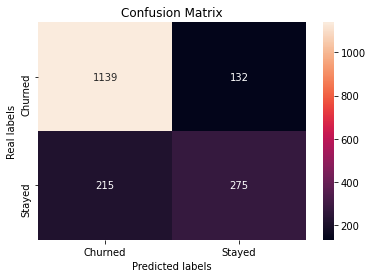

In [ ]:
#running the beautiful metrics function
produce_confusion('Stayed','Churned','binary',metric,'pred','Churn Value')

# Feature importance

In [ ]:
#list of columns
feature_names = list(X_test_eng.columns)
feature_names

['Monthly Charges',
 'Tenure Months',
 'Dependents_Yes',
 'Multiple Lines_Yes',
 'Internet Service_Fiber optic',
 'Online Security_Yes',
 'Tech Support_Yes',
 'Contract_Month-to-month',
 'Paperless Billing_Yes',
 'pred']

In [ ]:
#remove predictions if present
try:
    X_test_eng.drop(columns = 'pred', inplace = True)
    feature_names.remove('pred')
except:
    print('no pred')

In [ ]:
#code from the internet that calculates feature importance
from sklearn.inspection import permutation_importance
import time
import numpy as np

start_time = time.time()
result = permutation_importance(
    gs, X_test_eng, y_test, n_repeats=10, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)
forest_importances

Elapsed time to compute the importances: 9.855 seconds


Monthly Charges                 0.021408
Tenure Months                   0.059057
Dependents_Yes                  0.012720
Multiple Lines_Yes              0.005281
Internet Service_Fiber optic    0.024532
Online Security_Yes             0.008461
Tech Support_Yes                0.002385
Contract_Month-to-month         0.037365
Paperless Billing_Yes           0.008631
dtype: float64

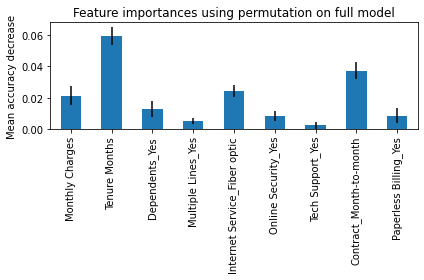

In [ ]:
#code from the internet that plots importances
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Churn risk list

In [ ]:
#reading in the original data
myDF = pd.read_excel('customer_churn.xlsx', header = 0)

In [ ]:
churn = myDF.copy()
#removing useless columns
try:
    churn.drop(columns = ['Churn Label','CustomerID', 'Count', 'Country', 'State','City','Lat Long', 'Latitude', 'Longitude', 'Churn Reason'], inplace = True)
except:
    print('Already dropped!')

In [ ]:
#only customers who have not left
loyal = churn[churn['Churn Value'] == 0]
loyal_eng = feature_eng(loyal)

loyal_eng

,Monthly Charges,Tenure Months,Dependents_Yes,Multiple Lines_Yes,Internet Service_Fiber optic,Online Security_Yes,Tech Support_Yes,Contract_Month-to-month,Paperless Billing_Yes
1869,29.85,1,0,0,0,0,0,1,1
1870,56.95,34,0,0,0,1,0,0,0
1871,42.30,45,0,0,0,1,1,0,0
1872,89.10,22,1,1,1,0,0,1,1
1873,29.75,10,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
7038,21.15,72,0,0,0,0,0,0,1
7039,84.80,24,1,1,0,1,1,0,1
7040,103.20,72,1,1,1,0,0,0,1
7041,29.60,11,1,0,0,1,0,1,1


In [ ]:
#adding CustomerID back to the DataFrame
loyal_id = myDF['CustomerID'][myDF['Churn Value'] == 0]
test = loyal_eng.join(loyal_id)
test.sort_values('Churn Probability', ascending= False, inplace = True)

In [ ]:
#list of all customers and risk
churn_list = test[['CustomerID', 'Churn Probability']]
churn_list

,CustomerID,Churn Probability
6213,1628-BIZYP,0.883002
5657,7577-SWIFR,0.873740
4481,2254-DLXRI,0.871454
2676,7439-DKZTW,0.869715
5906,4912-PIGUY,0.859782
...,...,...
4948,6248-BSHKG,0.000451
3881,4636-TVXVG,0.000451
2520,1764-VUUMT,0.000408
2330,2804-ETQDK,0.000408


In [ ]:
#save dataframe as csv file
churn_list.to_csv('RF_churn.csv', index = None)

In [ ]:
#top 500 by churn risk
top_500_list = test[['CustomerID', 'Churn Probability']].head(500)
top_500_list

,CustomerID,Churn Probability
6213,1628-BIZYP,0.883002
5657,7577-SWIFR,0.873740
4481,2254-DLXRI,0.871454
2676,7439-DKZTW,0.869715
5906,4912-PIGUY,0.859782
...,...,...
2739,1346-UFHAX,0.473142
3373,8543-MSDMF,0.472988
6957,9398-MMQTO,0.472730
5901,6538-POCHL,0.472390


In [ ]:
#save dataframe as csv file
top_500_list.to_csv('RF_top_500.csv', index = None)